In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader


In [2]:
# fix split 
import pandas as pd
import numpy as np


# Extract training set from MNIST dataset.
fashion_train_df = pd.read_csv('data_copy/raw/fashion-mnist-train.csv')
fashion_test_df = pd.read_csv('data_copy/raw/fashion-mnist-test.csv')


np.random.seed(0)

N = len(fashion_train_df)
indices = np.random.permutation(N)  # shuffled indices, reproducible because of seed

# Calculate absolute sizes
n_train = int(0.50 * N)   # 50%
n_val = int(0.10 * N)     # 10%
n_comb = N - (n_train + n_val)  # remaining 40%

# Assign splits
idx_train = indices[:n_train]
idx_val = indices[n_train:n_train + n_val]
idx_comb = indices[n_train + n_val:]

# Get DataFrames
train_df = fashion_train_df.iloc[idx_train]
val_df = fashion_train_df.iloc[idx_val]
comb_df = fashion_train_df.iloc[idx_comb]

print('train frame: ',len(train_df))
print('validation frame: ', len(val_df))
print('combination frame: ',len(comb_df))
print('test fram; ', len(fashion_test_df))

train frame:  30000
validation frame:  6000
combination frame:  24000
test fram;  10000


In [3]:
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.pool_1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.pool_2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        self.fc = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool_1(x)

        x = F.relu(self.conv2(x))
        x = self.pool_2(x)

        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x
    
model = CNN()

from torchinfo import summary
summary(model, input_size=(64, 1, 28, 28))



Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 10]                  --
├─Conv2d: 1-1                            [64, 8, 28, 28]           80
├─MaxPool2d: 1-2                         [64, 8, 14, 14]           --
├─Conv2d: 1-3                            [64, 16, 14, 14]          1,168
├─MaxPool2d: 1-4                         [64, 16, 7, 7]            --
├─Conv2d: 1-5                            [64, 32, 7, 7]            4,640
├─Linear: 1-6                            [64, 10]                  15,690
Total params: 21,578
Trainable params: 21,578
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 34.22
Input size (MB): 0.20
Forward/backward pass size (MB): 5.62
Params size (MB): 0.09
Estimated Total Size (MB): 5.91

In [4]:
# Lavy function for pixel dropout 
def hide_continuous(df, hide=[0.25, 0.75], hidden_value=0):
    """
    Hides a percentage of pixels in a dataframe 
    and returns two dataframes with different masking levels.

    Args:
        df: Input dataframe
        hide (list): List of two hiding ratios
        hidden_value: The value to replace the hidden pixels with.

    Returns:
        tuple: (df_first, df_second) - Two dataframes with the specified hiddden value applied.
    """
    # Set random seed for reproducibility
    np.random.seed(42)

    labels = df.iloc[:, 0].to_numpy()
    original_pixels = df.iloc[:, 1:].to_numpy(copy=True)  #copy to avoid modifying original df
    n_rows, n_pixels = original_pixels.shape
    
    hide_first_ratio = hide[0]
    hide_second_ratio = hide[1]

    #Calculate the number of pixels to hide for each ratio
    n_hide_first = int(n_pixels * hide_first_ratio)
    n_hide_second = int(n_pixels * hide_second_ratio)

    

    #Select indices to hide. We select the indices for the larger ratio first,
    # then use a subset of those for the smaller ratio.
    all_drop_indices = np.random.choice(
        n_pixels, 
        size=n_hide_second, 
        replace=False
    )
    
    # Indices for the smaller mask
    # Take the first n_hide_first elements of the larger set
    drop_indices_first = all_drop_indices[:n_hide_first] 
    
    # Indices for the larger mask 
    drop_indices_second = all_drop_indices 

    # first dataframe
    pixels_first = original_pixels.copy()
    # Mask rows at the selected columns
    pixels_first[:, drop_indices_first] = hidden_value 
    
    df_first = pd.DataFrame(
        pixels_first, 
        columns=df.columns[1:], 
        index=df.index
    )
    df_first.insert(0, 'label', labels)
    
    # second dataframe
    pixels_second = original_pixels.copy()
    # Mask all rows at the selected columns
    pixels_second[:, drop_indices_second] = hidden_value
    
    df_second = pd.DataFrame(
        pixels_second, 
        columns=df.columns[1:], 
        index=df.index
    )
    df_second.insert(0, 'label', labels)
    
    return df_first, df_second

In [5]:
print(fashion_train_df.shape)
# (60000, 785)  ← first column = label, 784 pixel columns

# Call the function to get two masked versions
train_hidden15, train_hidden85 = hide_continuous(train_df, hide=[0.15, 0.85], hidden_value=0)
val_hidden15, val_hidden85 = hide_continuous(val_df, hide=[0.15, 0.85], hidden_value=0)

fashion_test_df15, fashion_test_df85 = hide_continuous(fashion_test_df, hide=[0.15, 0.85], hidden_value=0)


# Separate features (X) and labels (y) from each split
X_train = train_hidden15.drop("label", axis=1).values
y_train = train_hidden15["label"].values

X_val = val_hidden15.drop("label", axis=1).values
y_val = val_hidden15["label"].values

X_comb = comb_df.drop("label", axis=1).values
y_comb = comb_df["label"].values

# Also prepare test set from the test CSV
X_test = fashion_test_df15.drop("label", axis=1).values
y_test = fashion_test_df15["label"].values

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Combination:", X_comb.shape, y_comb.shape)
print("Test:", X_test.shape, y_test.shape)





(60000, 785)
Train: (30000, 784) (30000,)
Validation: (6000, 784) (6000,)
Combination: (24000, 784) (24000,)
Test: (10000, 784) (10000,)


In [6]:
# Convert NumPy arrays → PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Wrap in TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoaders : think as a pipeline that delivers your data to the model in small, manageable pieces (batches).
batch_size = X_train.shape[0] // 20
# batch_size= 100
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
# This function is taken from deeplearning course assigment
def train_model(model, train_loader, val_loader, epochs=100, learning_rate=1e-3, patience=10):
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2) # efault optimizer used in modern neural network training (used by Hugging Face, PyTorch examples, etc.).
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)


    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    best_val_loss = float("inf")
    patience_counter = 0
    best_model_state = None

    start = time.perf_counter()

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs = inputs.view(-1, 1, 28, 28)  # reshape
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accs.append(100 * correct / total)

        # ---- Validation ----
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.view(-1, 1, 28, 28)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(100 * correct / total)

        # ---- Early Stopping ---- 
        # This section is added by AI and is used in cases where we decide to try higher epoc number
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
            best_model_state = model.state_dict()  # save best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)  # restore best model
                break

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss={train_losses[-1]:.4f}, Train Acc={train_accs[-1]:.2f}%, "
              f"Val Loss={val_losses[-1]:.4f}, Val Acc={val_accs[-1]:.2f}%")

    training_time = time.perf_counter() - start
    return train_losses, train_accs, val_losses, val_accs, training_time


In [8]:
print(batch_size)

train_losses, train_accs, val_losses, val_accs, training_time = train_model(
    model, train_loader, val_loader,
    epochs=100,         
    learning_rate=1e-4,  # safe for Adam
    patience=10
)


1500
Epoch 1/100: Train Loss=3.0433, Train Acc=50.18%, Val Loss=0.9440, Val Acc=65.70%
Epoch 2/100: Train Loss=0.7336, Train Acc=73.07%, Val Loss=0.5981, Val Acc=78.00%
Epoch 3/100: Train Loss=0.5309, Train Acc=80.66%, Val Loss=0.4871, Val Acc=82.85%
Epoch 4/100: Train Loss=0.4498, Train Acc=83.72%, Val Loss=0.4522, Val Acc=84.57%
Epoch 5/100: Train Loss=0.4069, Train Acc=85.40%, Val Loss=0.4245, Val Acc=85.58%
Epoch 6/100: Train Loss=0.3786, Train Acc=86.44%, Val Loss=0.4096, Val Acc=86.03%
Epoch 7/100: Train Loss=0.3577, Train Acc=87.14%, Val Loss=0.4110, Val Acc=85.68%
Epoch 8/100: Train Loss=0.3443, Train Acc=87.38%, Val Loss=0.3941, Val Acc=86.57%
Epoch 9/100: Train Loss=0.3305, Train Acc=88.07%, Val Loss=0.3865, Val Acc=86.38%
Epoch 10/100: Train Loss=0.3167, Train Acc=88.57%, Val Loss=0.3827, Val Acc=86.95%
Epoch 11/100: Train Loss=0.3086, Train Acc=88.87%, Val Loss=0.3826, Val Acc=86.85%
Epoch 12/100: Train Loss=0.2963, Train Acc=89.27%, Val Loss=0.3773, Val Acc=87.02%
Epoch 13

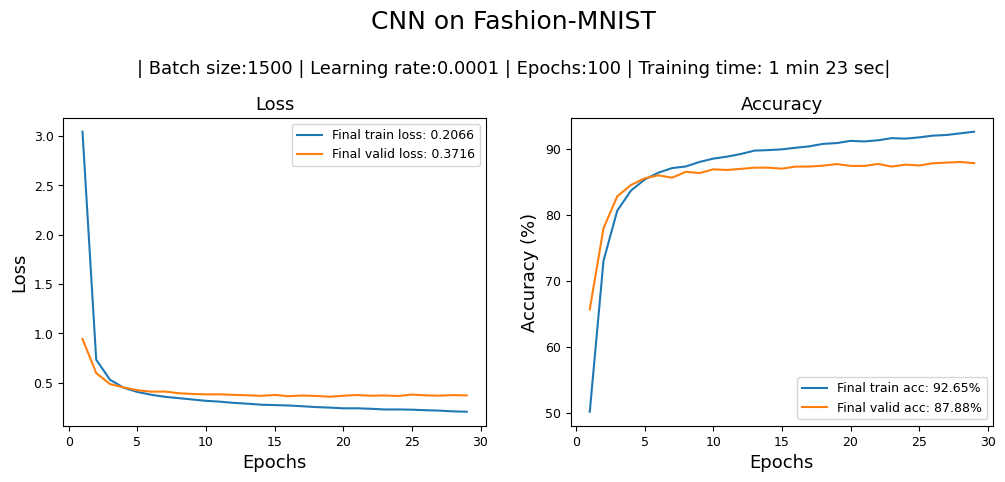

In [9]:
from matplotlib import pyplot as plt
import numpy as np

def training_curve_plot(title, train_costs, valid_costs, train_accuracies, valid_accuracies, batch_size, learning_rate, training_time, epochs):
    lg=18
    md=13
    sm=9
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, y=1.15, fontsize=lg)
    
    mins, secs = divmod(training_time, 60)
    sub = f'| Batch size:{batch_size} | Learning rate:{learning_rate} | Epochs:{epochs} | Training time: {int(mins)} min {secs:.0f} sec|'
    fig.text(0.5, 0.99, sub, ha='center', fontsize=md)
    
    x = range(1, len(train_costs)+1)

    # ---- Loss plot ----
    axs[0].plot(x, train_costs, label=f'Final train loss: {train_costs[-1]:.4f}')
    axs[0].plot(x, valid_costs, label=f'Final valid loss: {valid_costs[-1]:.4f}')
    axs[0].set_title('Loss', fontsize=md)
    axs[0].set_xlabel('Epochs', fontsize=md)
    axs[0].set_ylabel('Loss', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)

    # ---- Accuracy plot ----
    axs[1].plot(x, train_accuracies, label=f'Final train acc: {train_accuracies[-1]:.2f}%')
    axs[1].plot(x, valid_accuracies, label=f'Final valid acc: {valid_accuracies[-1]:.2f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Epochs', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=md)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)

    plt.show()

training_curve_plot(
    "CNN on Fashion-MNIST",
    train_losses,     # training loss
    val_losses,       # validation loss
    train_accs,       # training accuracy
    val_accs,         # validation accuracy
    batch_size= batch_size,
    learning_rate=1e-4,
    training_time=training_time,
    epochs=100
)


In [10]:
# Final evaluation on test set
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.view(-1, 1, 28, 28)  # adjust shape if needed
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")


Final Test Accuracy: 88.12%


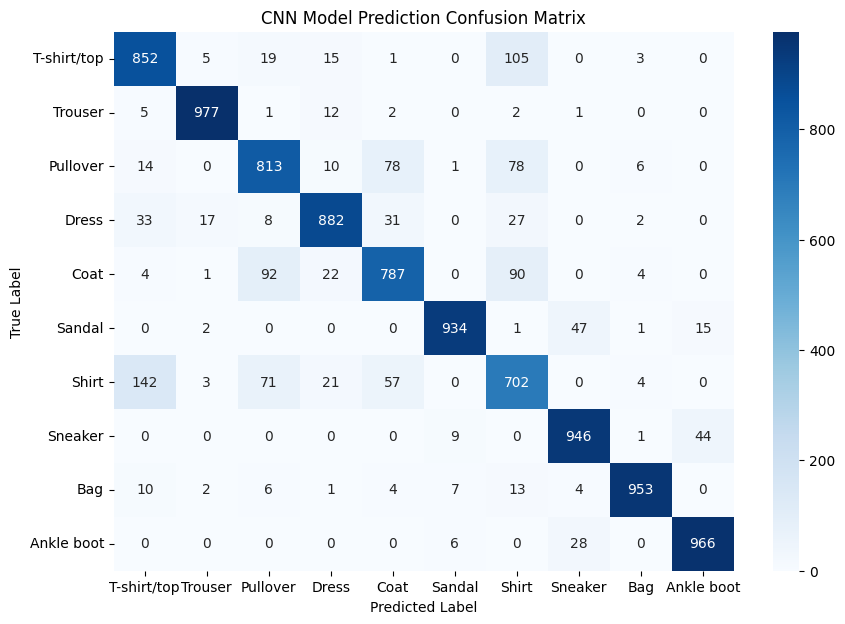

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# AI generated and taken from Deep learning assigment 
def get_predictions(model, loader, device="cpu"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # reshape if flattened
            if inputs.ndim == 2 and inputs.shape[1] == 784:
                inputs = inputs.view(-1, 1, 28, 28)
            
            outputs = model(inputs)  # logits
            _, preds = torch.max(outputs, 1)  # class indices

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]
# Testing the value with the testset 
y_true, y_pred_classes = get_predictions(model, test_loader)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("CNN Model Prediction Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [12]:
print(classification_report(y_test, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.80      0.85      0.83      1000
     Trouser       0.97      0.98      0.97      1000
    Pullover       0.80      0.81      0.81      1000
       Dress       0.92      0.88      0.90      1000
        Coat       0.82      0.79      0.80      1000
      Sandal       0.98      0.93      0.95      1000
       Shirt       0.69      0.70      0.70      1000
     Sneaker       0.92      0.95      0.93      1000
         Bag       0.98      0.95      0.97      1000
  Ankle boot       0.94      0.97      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [13]:
# This function is AI generated 
def show_random_predictions(test_loader, all_preds, all_labels, class_names, num_images=10):
    indices = np.random.choice(len(all_labels), num_images, replace=False)

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        # Get image and true label from dataset
        image, label = test_loader.dataset[idx]
        predicted_label = all_preds[idx]

        plt.subplot(2, 5, i + 1)
        
        # If image is flattened, reshape to 28x28
        if image.ndim == 1:
            image = image.view(28, 28)
        elif image.ndim == 3:  # (1, 28, 28)
            image = image.squeeze(0)

        plt.imshow(image.cpu().numpy(), cmap="gray")
        plt.axis("off")

        # Green title if correct, red if wrong
        color = "green" if predicted_label == label else "red"
        plt.title(f"True: {class_names[label]}\nPred: {class_names[predicted_label]}",
                  fontsize=10, color=color)

    plt.tight_layout()
    plt.show()


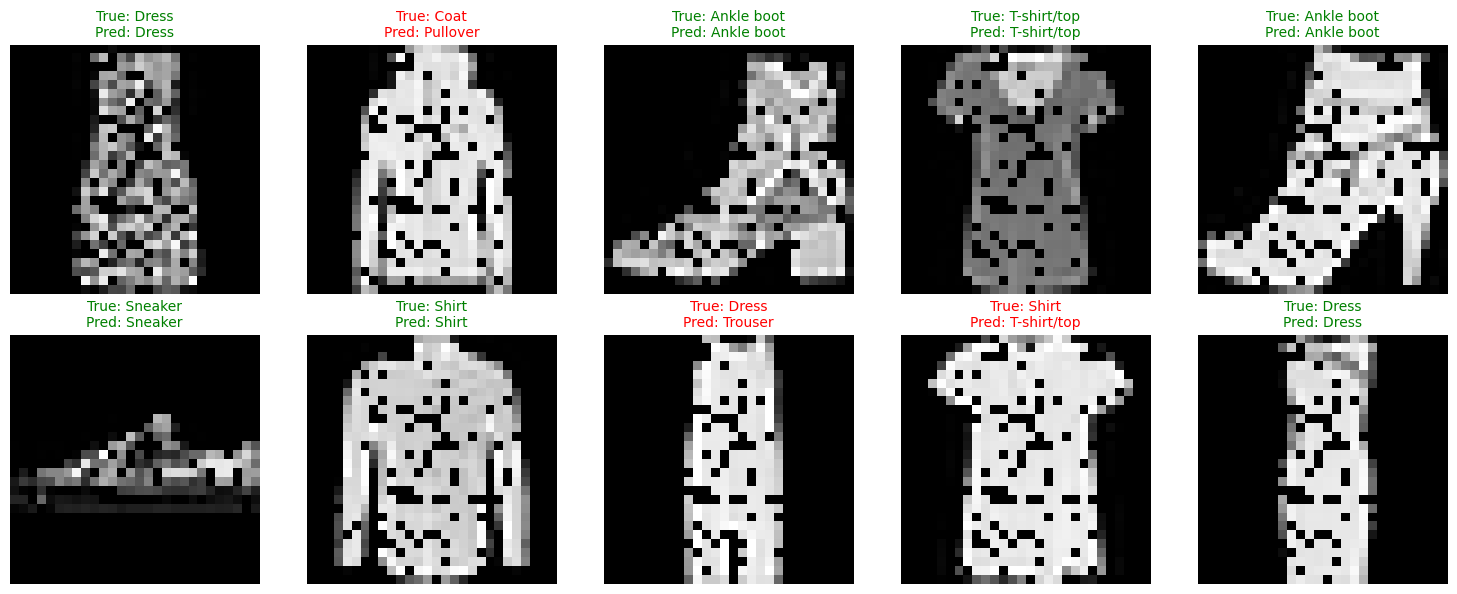

In [14]:
show_random_predictions(test_loader, y_pred_classes, y_true, class_names, num_images=10)
